<a href="https://colab.research.google.com/github/habrev/Rossmann-Pharmaceuticals/blob/task-2/notebooks/prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependency

In [10]:
import pandas as pd
import matplotlib as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset merging

# file imported

In [5]:
train = pd.read_csv('train.csv')
store = pd.read_csv('store.csv')

In [9]:
# Merge the datasets on the 'Store' column
merged_data = pd.merge(train, store, on='Store', how='left')

# Display the first few rows of the merged dataset
print(merged_data.head())

# Save the merged dataset to a CSV file (optional)
output_path = 'merged_data.csv'
merged_data.to_csv(output_path, index=False)
print(f"\nmerged file saved to {output_path}")

   Store  DayOfWeek        Date    Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263.0      555.0   1.0    1.0            0   
1      2          5  2015-07-31   6064.0      625.0   1.0    1.0            0   
2      3          5  2015-07-31   8314.0      821.0   1.0    1.0            0   
3      4          5  2015-07-31  13995.0     1498.0   1.0    1.0            0   
4      5          5  2015-07-31   4822.0      559.0   1.0    1.0            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0            1.0         c          a               1270.0   
1            1.0         a          a                570.0   
2            1.0         a          a              14130.0   
3            1.0         c          c                620.0   
4            1.0         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1       

# Preprocessing

In [13]:
# Load the merged dataset
merged_data = pd.read_csv('merged_data.csv')


# Convert 'Date' to datetime, coercing errors
merged_data['Date'] = pd.to_datetime(merged_data['Date'], errors='coerce')

# Check for invalid dates and print a summary
invalid_dates = merged_data[merged_data['Date'].isnull()]
if not invalid_dates.empty:
    print(f"Invalid dates found and removed:\n{invalid_dates}")

# Remove rows with invalid or missing dates
merged_data.dropna(subset=['Date'], inplace=True)

# Step 1: Handle missing values
# Fill missing competition data with default values
merged_data['CompetitionDistance'].fillna(merged_data['CompetitionDistance'].median(), inplace=True)
merged_data['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
merged_data['CompetitionOpenSinceYear'].fillna(0, inplace=True)

# Fill missing promo2 data with default values
merged_data['Promo2SinceWeek'].fillna(0, inplace=True)
merged_data['Promo2SinceYear'].fillna(0, inplace=True)
merged_data['PromoInterval'].fillna('None', inplace=True)

# Step 2: Feature engineering
# Convert date column to datetime
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# Extract temporal features from the date
merged_data['Year'] = merged_data['Date'].dt.year
merged_data['Month'] = merged_data['Date'].dt.month
merged_data['Day'] = merged_data['Date'].dt.day
merged_data['WeekOfYear'] = merged_data['Date'].dt.isocalendar().week
merged_data['DayOfYear'] = merged_data['Date'].dt.dayofyear
merged_data['DayOfWeek'] = merged_data['Date'].dt.dayofweek

# Beginning, mid, or end of the month
def month_stage(day):
    if day <= 10:
        return 'beginning'
    elif day <= 20:
        return 'mid'
    else:
        return 'end'

merged_data['MonthStage'] = merged_data['Day'].apply(month_stage)

# Compute competition age in months
merged_data['CompetitionAgeMonths'] = ((merged_data['Year'] - merged_data['CompetitionOpenSinceYear']) * 12 +
                                       (merged_data['Month'] - merged_data['CompetitionOpenSinceMonth']))
merged_data['CompetitionAgeMonths'] = merged_data['CompetitionAgeMonths'].apply(lambda x: max(x, 0))

# Step 3: Encode categorical variables

# Encode 'MonthStage' as numerical
month_stage_mapping = {'beginning': 1, 'mid': 2, 'end': 3}
merged_data['MonthStage'] = merged_data['MonthStage'].map(month_stage_mapping)
# Encode 'StateHoliday' as numerical
merged_data['StateHoliday'] = merged_data['StateHoliday'].replace({0: '0', '0': '0'})  # Ensure consistency
label_encoders = {}
for col in ['StoreType', 'Assortment', 'PromoInterval', 'StateHoliday']:
    label_enc = LabelEncoder()
    merged_data[col] = label_enc.fit_transform(merged_data[col])
    label_encoders[col] = label_enc  # Save encoders for later use



# Step 5: Check for any remaining missing values
if merged_data.isnull().sum().any():
    print("Warning: Missing values detected!")
    print(merged_data.isnull().sum())
else:
    print("No missing values remain!")

# Save the preprocessed dataset (optional)
merged_data.to_csv('preprocessed_data.csv', index=False)

# Display the first few rows of the preprocessed dataset
print(merged_data.head())


<ipython-input-13-f32e1f168849>:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_data = pd.read_csv('merged_data.csv')
<ipython-input-13-f32e1f168849>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['CompetitionDistance'].fillna(merged_data['CompetitionDistance'].median(), inplace=True)
<ipython-input-13-f32e1f168849>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
T

Invalid dates found and removed:
        Store  DayOfWeek Date  Sales  Customers  Open  Promo StateHoliday  \
196219   1095          5  NaT    NaN        NaN   NaN    NaN          NaN   

        SchoolHoliday StoreType Assortment  CompetitionDistance  \
196219            NaN         a          a                690.0   

        CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
196219                        6.0                    2007.0       1   

        Promo2SinceWeek  Promo2SinceYear    PromoInterval  
196219             14.0           2011.0  Jan,Apr,Jul,Oct  
No missing values remain!
   Store  DayOfWeek       Date    Sales  Customers  Open  Promo  StateHoliday  \
0      1          4 2015-07-31   5263.0      555.0   1.0    1.0             0   
1      2          4 2015-07-31   6064.0      625.0   1.0    1.0             0   
2      3          4 2015-07-31   8314.0      821.0   1.0    1.0             0   
3      4          4 2015-07-31  13995.0     1498.0   1.0    1.0 

# Model building with sklearn pipelines

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [17]:
# Load the preprocessed dataset
data = pd.read_csv('preprocessed_data.csv')

# Step 1: Define features (X) and target (y)
X = data.drop(['Sales', 'Date'], axis=1)  # Features
y = data['Sales']  # Target variable

# Step 2: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Define the pipeline
pipeline = Pipeline([
    ('model', RandomForestRegressor(random_state=42, n_estimators=100))  # Random Forest
])

# Step 4: Train the model
pipeline.fit(X_train, y_train)

# Step 5: Make predictions
y_pred = pipeline.predict(X_test)

# Step 6: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")

# Optional: Save the pipeline for deployment
import joblib
joblib.dump(pipeline, 'random_forest_pipeline.pkl')


Model Evaluation:
Mean Squared Error (MSE): 246298.6746
R-squared (R2 Score): 0.9833


['random_forest_pipeline.pkl']

In [19]:
from sklearn.preprocessing import StandardScaler
df = pd.read_csv('preprocessed_data.csv')
# Identify numerical columns to scale
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Initialize the scaler
scaler = StandardScaler()

# Scale the numerical columns
df_scaled = df.copy()
df_scaled[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Save the scaled dataset
scaled_output_path = 'scaled_dataset.csv'
df_scaled.to_csv(scaled_output_path, index=False)

# Display a preview of the scaled DataFrame
print(f"Scaled Data saved to {scaled_output_path}")
print(df_scaled.head())

Scaled Data saved to scaled_dataset.csv
      Store  DayOfWeek        Date     Sales  Customers      Open     Promo  \
0 -1.730491   0.498257  2015-07-31 -0.161430  -0.155163  0.453279  1.291179   
1 -1.727384   0.498257  2015-07-31  0.046087  -0.001534  0.453279  1.291179   
2 -1.724277   0.498257  2015-07-31  0.629000   0.428627  0.453279  1.291179   
3 -1.721170   0.498257  2015-07-31  2.100791   1.914440  0.453279  1.291179   
4 -1.718063   0.498257  2015-07-31 -0.275681  -0.146384  0.453279  1.291179   

   StateHoliday  SchoolHoliday  StoreType  ...  Promo2SinceWeek  \
0      -0.17199       2.345646   0.571928  ...        -0.777794   
1      -0.17199       2.345646  -0.889054  ...         0.058993   
2      -0.17199       2.345646  -0.889054  ...         0.123361   
3      -0.17199       2.345646   0.571928  ...        -0.777794   
4      -0.17199       2.345646  -0.889054  ...        -0.777794   

   Promo2SinceYear  PromoInterval  Year     Month       Day  WeekOfYear  \
0      

# Feature importance

Model Evaluation:
Mean Squared Error (MSE): 0.9871
R-squared (R2 Score): -0.0000


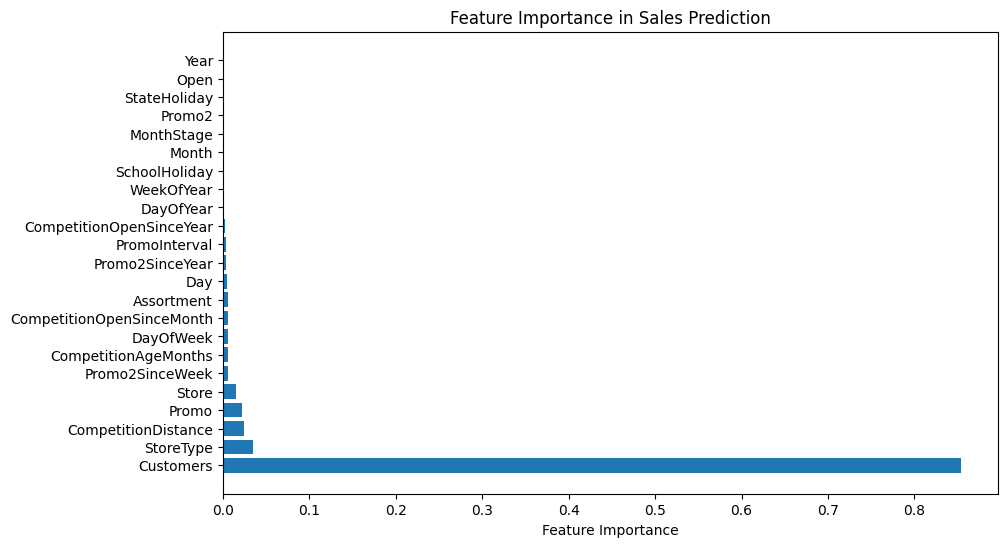

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_squared_error, r2_score

# Load the preprocessed and scaled dataset
data = pd.read_csv('scaled_dataset.csv')

# Define features (X) and target (y)
X = data.drop(columns=['Sales', 'Date'])  # Dropping 'Sales' and 'Date' columns
y = data['Sales']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the pre-trained Random Forest pipeline
model = joblib.load('random_forest_pipeline.pkl')

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")

# -- Feature Importance --
# Extract feature importance from the pipeline
feature_importances = model.named_steps['model'].feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Sales Prediction')
plt.show()

# -- Confidence Interval Estimation via Bootstrapping --
def bootstrap_confidence_interval(model, X, y, n_iterations=1000, ci=95):
    predictions = []

    for i in range(n_iterations):
        # Resample with replacement
        sample_indices = np.random.choice(len(X), size=len(X), replace=True)
        X_sample, y_sample = X.iloc[sample_indices], y.iloc[sample_indices]

        # Fit the model on the bootstrap sample
        model.fit(X_sample, y_sample)

        # Make predictions on the original test data
        y_pred = model.predict(X_test)
        predictions.append(y_pred)

    # Convert predictions to a numpy array
    predictions = np.array(predictions)

    # Calculate the lower and upper bounds of the confidence interval
    lower_bound = np.percentile(predictions, (100 - ci) / 2, axis=0)
    upper_bound = np.percentile(predictions, 100 - (100 - ci) / 2, axis=0)

    return lower_bound, upper_bound

# Estimate 95% confidence intervals for the predictions
lower_bound, upper_bound = bootstrap_confidence_interval(model, X_train, y_train, n_iterations=1000, ci=95)

# Display the confidence intervals for the first 10 predictions
for i in range(10):
    print(f"Prediction {i+1}: {y_pred[i]:.2f} (CI: [{lower_bound[i]:.2f}, {upper_bound[i]:.2f}])")

# Plotting the predictions with confidence intervals
plt.figure(figsize=(10, 6))

# Plot the predicted values
plt.plot(y_pred, label='Predictions', color='blue', alpha=0.7)

# Plot the confidence intervals
plt.fill_between(range(len(y_pred)), lower_bound, upper_bound, color='gray', alpha=0.2, label='95% CI')

plt.xlabel('Test Samples')
plt.ylabel('Sales Predictions')
plt.title('Sales Predictions with 95% Confidence Intervals')
plt.legend()
plt.show()
